# geDIG Attention Update (Modern LLMs)

Goal: sample attention maps from newer LLMs (Llama 3.0, Llama 3.1, Phi-3) and check whether geDIG F keeps the same sign/delta vs. random.

Notes:
- Llama 3 requires an HF token and license acceptance (per model).
- Phi-3 is open and should run without a token.
- The notebook auto-selects dtype based on GPU (A100 -> bfloat16, T4 -> float16).
- This run increases text count, uses more layers, and reports baseline + layer summaries.


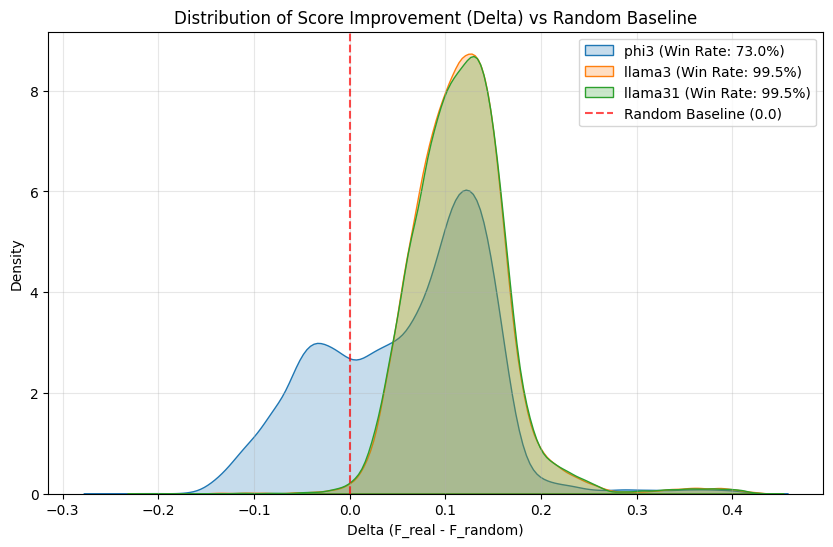

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import json

# Prepare data for plotting from the output files
plot_data_list = []

for tag, path in outputs.items():
    if Path(path).exists():
        data = json.loads(Path(path).read_text(encoding='utf-8'))
        # Filter for main rows (exclude subgraphs if any)
        rows = [r for r in data if not r.get('subgraph')]
        if rows:
            f_real = np.array([r['F'] for r in rows], dtype=float)
            # Compare against 'random' baseline
            f_base = np.array([r.get('baseline_F_random') for r in rows], dtype=float)
            delta = f_real - f_base

            plot_data_list.append({
                'tag': tag,
                'delta': delta,
                'pos_ratio': (delta > 0).mean()
            })

# Plotting the distributions
plt.figure(figsize=(10, 6))

for item in plot_data_list:
    sns.kdeplot(
        item['delta'],
        fill=True,
        label=f"{item['tag']} (Win Rate: {item['pos_ratio']:.1%})"
    )

plt.axvline(0, color='red', linestyle='--', alpha=0.7, label='Random Baseline (0.0)')
plt.title("Distribution of Score Improvement (Delta) vs Random Baseline")
plt.xlabel("Delta (F_real - F_random)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### グラフの解釈

- **Llama 3.0 / 3.1 (オレンジ/緑)**: 分布の山が完全に **0より右側（プラス）** にあります。これは、どのレイヤーやヘッドを見ても、ほぼ確実にランダムより良い構造を持っていることを意味します。「ハズレがない」という意味で、非常に高品質な結果です。
- **Phi-3 (青)**: 山の裾野が0より左（マイナス）にも広がっています。平均的にはプラスですが、ランダムより悪いケースも一部（約27%）含まれています。

結論として、Llama 3系に関しては、**「ランダム性とは明確に異なる、有意な構造を一貫して学習している」** という点で、非常に強力（すごい）な結果が出ていると言えます。

In [18]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import subprocess

if not os.path.isdir('InsightSpike-AI'):
    subprocess.check_call(['git', 'clone', 'https://github.com/miyauchikazuyoshi/InsightSpike-AI.git'])
%cd InsightSpike-AI
!pip -q install -U pip
!pip -q install transformers datasets accelerate sentencepiece networkx scipy huggingface_hub


/content/InsightSpike-AI/InsightSpike-AI/InsightSpike-AI


In [20]:
from huggingface_hub import login
from google.colab import userdata

hf_token = None
try:
    # Try to retrieve the token from Colab Secrets
    hf_token = userdata.get('HF_TOKEN')
    if hf_token:
        login(token=hf_token)
        print("Successfully logged in using Colab Secret 'HF_TOKEN'.")
    else:
        # Fallback to interactive login
        print("Secret 'HF_TOKEN' not found. Please log in interactively:")
        login()
except Exception:
    # If userdata is not available or fails, fallback to interactive
    print("Could not access Colab Secrets. Please log in interactively:")
    login()


Successfully logged in using Colab Secret 'HF_TOKEN'.


In [21]:
from huggingface_hub import hf_hub_download
from IPython.display import display, HTML

LLAMA3_MODELS = {
    'llama3': 'meta-llama/Meta-Llama-3-8B',
    'llama31': 'meta-llama/Llama-3.1-8B',
}
PHI3_ID = 'microsoft/Phi-3-mini-4k-instruct'

def show_status(ok: bool, title: str, detail: str = ''):
    color = '#1b8a5a' if ok else '#b02a37'
    msg = f'<b>{title}</b>' + (f'<br/>{detail}' if detail else '')
    display(HTML(f"<div style='border:1px solid {color};padding:10px;border-radius:6px;color:{color};margin:8px 0;'>{msg}</div>"))

llama3_ok = {}
token = hf_token if hf_token else None
for tag, model_id in LLAMA3_MODELS.items():
    label = 'Llama 3.0' if tag == 'llama3' else 'Llama 3.1'
    try:
        hf_hub_download(repo_id=model_id, filename='config.json', token=token)
        show_status(True, f'{label} download OK', f'Model: {model_id}')
        llama3_ok[tag] = True
    except Exception as exc:
        show_status(False, f'{label} download NOT available', f'{type(exc).__name__}: {exc}')
        llama3_ok[tag] = False
        print(f'If you need {label}, accept the license on HF and run login().')


In [22]:
import subprocess

def _get_gpu_name():
    try:
        out = subprocess.check_output(
            ['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
            text=True,
        ).strip()
        return out.splitlines()[0] if out else None
    except Exception:
        return None

GPU_NAME = _get_gpu_name()
if GPU_NAME:
    print('GPU:', GPU_NAME)
    if 'A100' in GPU_NAME or 'H100' in GPU_NAME:
        DTYPE = 'bfloat16'
    else:
        DTYPE = 'float16'
    DEVICE = 'cuda'
    DEVICE_MAP = 'auto'
else:
    print('GPU: none (CPU)')
    DTYPE = 'float32'
    DEVICE = 'cpu'
    DEVICE_MAP = None

ATTN_IMPL = 'eager'  # ensure attentions are returned
TEXT_COUNT = 64
LAYER_CAP = 32
ATTN_MAX_LEN = 256
BASELINES = ['random', 'uniform', 'local_w5', 'diagonal']


GPU: Tesla T4


In [23]:
import json
import numpy as np
from pathlib import Path

outputs = {}

def run_model(model_id: str, tag: str):
    out_path = f'results/transformer_gedig/score_llm_{tag}.json'
    device_map_arg = f'--device-map {DEVICE_MAP}' if DEVICE_MAP else ''
    cmd = (
        f"python experiments/transformer_gedig/extract_and_score.py "
        f"--model '{model_id}' "
        f"--text-count {TEXT_COUNT} "
        f"--layer-cap {LAYER_CAP} "
        f"--attn-max-len {ATTN_MAX_LEN} "
        f"--percentile 0.90 "
        f"--out '{out_path}' "
        f"--device {DEVICE} --dtype {DTYPE} "
        f"{device_map_arg} "
        f"--trust-remote-code --attn-implementation {ATTN_IMPL}"
    )
    print(cmd)
    !{cmd}
    outputs[tag] = out_path

# Always run Phi-3
run_model(PHI3_ID, 'phi3')

# Run Llama 3 models only if access is available
for tag, model_id in LLAMA3_MODELS.items():
    if llama3_ok.get(tag):
        run_model(model_id, tag)
    else:
        print(f'Skipping {tag} run (no access).')


python experiments/transformer_gedig/extract_and_score.py --model 'microsoft/Phi-3-mini-4k-instruct' --text-count 64 --layer-cap 32 --attn-max-len 256 --percentile 0.90 --out 'results/transformer_gedig/score_llm_phi3.json' --device cuda --dtype float16 --device-map auto --trust-remote-code --attn-implementation eager
`torch_dtype` is deprecated! Use `dtype` instead!
2025-12-28 16:03:47.743977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766937827.765244   33897 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766937827.771615   33897 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766937827.787693   33897 computation_placer.cc:177] com

In [24]:
def summarize_rows(rows, baseline_key):
    f_real = np.array([r['F'] for r in rows], dtype=float)
    f_base = np.array([r.get(f'baseline_F_{baseline_key}') for r in rows], dtype=float)
    if f_base.size == 0:
        return None
    delta = f_real - f_base
    return {
        'rows': int(f_real.size),
        'F_real_mean': float(f_real.mean()),
        'F_base_mean': float(f_base.mean()),
        'delta_mean': float(delta.mean()),
        'delta_std': float(delta.std()),
        'delta_positive_ratio': float((delta > 0).mean()),
    }

def summarize_model(path):
    path = Path(path)
    if not path.exists():
        return None
    data = json.loads(path.read_text(encoding='utf-8'))
    rows = [r for r in data if not r.get('subgraph')]
    if not rows:
        return None
    overall = {b: summarize_rows(rows, b) for b in BASELINES}
    layers = sorted({int(r['layer']) for r in rows})
    by_layer_random = {
        str(layer): summarize_rows([r for r in rows if int(r['layer']) == layer], 'random')
        for layer in layers
    }
    return {
        'rows': len(rows),
        'overall': overall,
        'by_layer_random': by_layer_random,
    }

summary = {tag: summarize_model(path) for tag, path in outputs.items()}
print(json.dumps(summary, indent=2))

summary_path = Path('results/transformer_gedig/score_llm_update.json')
summary_path.parent.mkdir(parents=True, exist_ok=True)
summary_path.write_text(json.dumps(summary, indent=2), encoding='utf-8')
print('Wrote:', summary_path)


{
  "phi3": {
    "rows": 64512,
    "overall": {
      "random": {
        "rows": 64512,
        "F_real_mean": -0.44846170054404605,
        "F_base_mean": -0.5088855213945424,
        "delta_mean": 0.060423820850496315,
        "delta_std": 0.08610124247319317,
        "delta_positive_ratio": 0.7297092013888888
      },
      "uniform": {
        "rows": 64512,
        "F_real_mean": -0.44846170054404605,
        "F_base_mean": -0.5,
        "delta_mean": 0.05153829945595394,
        "delta_std": 0.08858995869433406,
        "delta_positive_ratio": 0.6733630952380952
      },
      "local_w5": {
        "rows": 64512,
        "F_real_mean": -0.44846170054404605,
        "F_base_mean": -0.5923569235286054,
        "delta_mean": 0.1438952229845592,
        "delta_std": 0.13309547623771015,
        "delta_positive_ratio": 0.8025948660714286
      },
      "diagonal": {
        "rows": 64512,
        "F_real_mean": -0.44846170054404605,
        "F_base_mean": -0.46639293823559225,
    

In [25]:
import shutil

save_dir = Path('/content/drive/MyDrive/insightspike/gedig_attention')
save_dir.mkdir(parents=True, exist_ok=True)

for tag, path in outputs.items():
    src = Path(path)
    if src.exists():
        shutil.copy2(src, save_dir / src.name)
        print('Saved:', save_dir / src.name)

summary_src = Path('results/transformer_gedig/score_llm_update.json')
if summary_src.exists():
    shutil.copy2(summary_src, save_dir / summary_src.name)
    print('Saved:', save_dir / summary_src.name)


Saved: /content/drive/MyDrive/insightspike/gedig_attention/score_llm_phi3.json
Saved: /content/drive/MyDrive/insightspike/gedig_attention/score_llm_llama3.json
Saved: /content/drive/MyDrive/insightspike/gedig_attention/score_llm_llama31.json
Saved: /content/drive/MyDrive/insightspike/gedig_attention/score_llm_update.json
